In [ ]:
# !pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

# Environment test

In [293]:
import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym


env = gym.make("TextFlappyBird-v0")
obs, info = env.reset()

print("number of actions", env.action_space.n)
print("action space", env.action_space)
print("observation space", env.observation_space)

print("obs", obs)
print("info", info)
steps = 0
while True:

    # Select next action
    action = (
        env.action_space.sample()
    )  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    steps += 1

    print("--------------------", steps, "--------------------")
    print("action", action)
    print("obs", obs)
    print("reward", reward)
    print("done", done)
    print("info", info)

    if done or steps > 100:
        break

    break

number of actions 2
action space Discrete(2)
observation space Tuple(Discrete(14), Discrete(22, start=-11))
obs (13, -2)
info {'score': 0, 'player': [6, 7], 'distance': 13.152946437965905}
-------------------- 1 --------------------
action 1
obs (12, -3)
reward 1
done False
info {'score': 0, 'player': [6, 6], 'distance': 12.36931687685298}


In [193]:
from collections import defaultdict


def evaluate_policy(env, policy, num_episodes=100):
    rewards = []
    for _ in range(num_episodes):

        obs, _ = env.reset()
        episode_reward = 0
        done = False
        steps = 0
        while not done:
            action = policy[obs]
            obs, reward, done, _, _ = env.step(action)
            episode_reward += reward
            steps += 1
            if steps > 10000:  # break if the episode is too long
                break
        rewards.append(episode_reward)

    return sum(rewards) / num_episodes


random_policy = defaultdict(lambda: env.action_space.sample())
avg_reward = evaluate_policy(env, random_policy, 1000)
print(avg_reward)

zero_policy = defaultdict(lambda: 0)
avg_reward = evaluate_policy(env, zero_policy, 100)
print(avg_reward)

one_policy = defaultdict(lambda: 1)
avg_reward = evaluate_policy(env, one_policy, 100)
print(avg_reward)

9.342
4.0
13.0


# MC Control

In [211]:
import numpy as np


def generate_episode_from_Q(env, Q, epsilon, nA):
    """generates an episode from following the epsilon-greedy policy"""
    episode = []
    state, _ = env.reset()
    while True:
        action = (
            np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))
            if state in Q
            else env.action_space.sample()
        )
        # take a step in the environement
        next_state, reward, done, _, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode


def get_probs(Q_s, epsilon, nA):
    """obtains the action probabilities corresponding to epsilon-greedy policy"""
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s


def update_Q(env, episode, Q, alpha, gamma):
    """updates the action-value function estimate using the most recent episode"""
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards) + 1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha * (
            sum(rewards[i:] * discounts[: -(1 + i)]) - old_Q
        )
    return Q


def mc_control(
    env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=0.99999, eps_min=0.05
):
    avg_rewards = []
    episodes = []
    best_policy = defaultdict(lambda: 0)
    best_avg_reward = 0

    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start

    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress and evaluate the policy
        if i_episode % 1000 == 0:

            policy = defaultdict(lambda: 0)
            for state, actions in Q.items():
                policy[state] = np.argmax(actions)
            avg_reward = evaluate_policy(env, policy, num_episodes=100)
            avg_rewards.append(avg_reward)
            episodes.append(i_episode)

            if avg_reward >= best_avg_reward:
                best_avg_reward = avg_reward
                best_policy = policy

            print("\rEpisode {}/{}. ".format(i_episode, num_episodes), end="")
            print("Average reward: {}".format(avg_reward), end="")

            # sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon * eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k, np.argmax(v)) for k, v in Q.items())

    return policy, Q, avg_rewards, episodes, best_policy, best_avg_reward

In [212]:
policy, Q, avg_rewards, episodes, best_policy, best_avg_reward = mc_control(
    env, 50000, 0.02
)

avg_reward = evaluate_policy(env, policy, 1000)
print(avg_reward)

Episode 50000/50000. Average reward: 781.540628.285


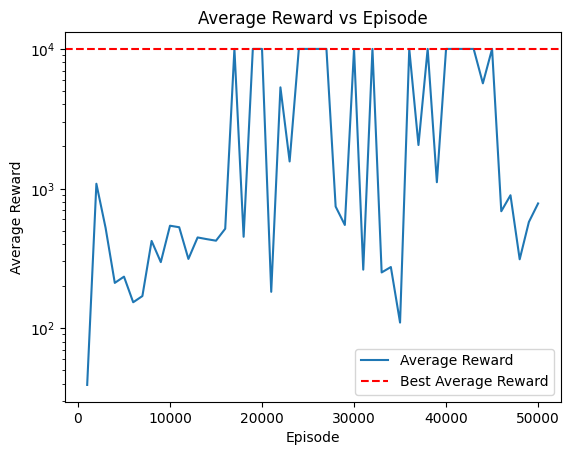

In [291]:
import matplotlib.pyplot as plt

plt.plot(episodes, avg_rewards, label="Average Reward")
plt.axhline(best_avg_reward, color="r", linestyle="--", label="Best Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.yscale("log")
plt.legend()
plt.title("Average Reward vs Episode")
plt.show()

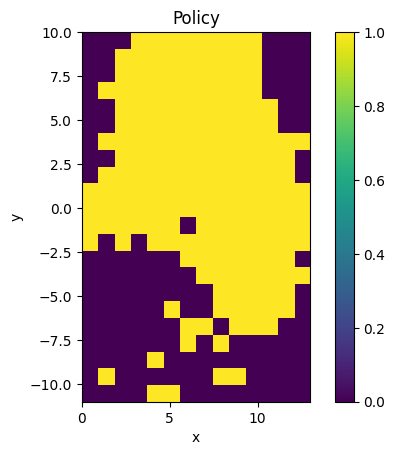

In [227]:
def plot_policy(policy):
    """
    Plot the policy
    States are a tuple (x, y) Tuple(Discrete(14), Discrete(22, start=-11))
    Action space Discrete(2)
    """

    x = np.arange(14)
    y = np.arange(-11, 11)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            state = (X[i, j], Y[i, j])
            Z[i, j] = policy[state]

    plt.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Policy")
    plt.show()


plot_policy(best_policy)

This figure shows that the MC control algorithm approximatively learns to flap if the bird is too low and not to flap if the bird is too high for small x which is rather expected.

In [290]:
simple_policy = {}

for x in range(14):
    for y in range(-30, 30):
        state = (x, y)
        simple_policy[state] = 0 if y < 0 else 1

avg_reward = evaluate_policy(env, simple_policy, 1000)
print(avg_reward)

248.268


# Sarsa lambda

In [296]:
def choose_action(env, state, Q, epsilon):
    if not state in Q or np.random.random() < epsilon:
        return env.action_space.sample()

    return np.argmax(Q[state])


def sarsa_lambda_agent(
    env,
    num_episodes,
    alpha,
    lambda_=1,
    gamma=1.0,
    eps_start=1.0,
    eps_decay=0.99999,
    eps_min=0.05,
):
    avg_rewards = []
    episodes = []
    best_policy = defaultdict(lambda: 0)
    best_avg_reward = 0

    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    visited = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start

    for i_episode in range(1, num_episodes + 1):
        # monitor progress and evaluate the policy
        if i_episode % 1000 == 0:

            policy = defaultdict(lambda: 0)
            for state, actions in Q.items():
                policy[state] = np.argmax(actions)
            avg_reward = evaluate_policy(env, policy, num_episodes=100)
            avg_rewards.append(avg_reward)
            episodes.append(i_episode)

            if avg_reward >= best_avg_reward:
                best_avg_reward = avg_reward
                best_policy = policy

            print("\rEpisode {}/{}. ".format(i_episode, num_episodes), end="")
            print("Average reward: {}".format(avg_reward), end="")

            # sys.stdout.flush()

        # set the value of epsilon
        epsilon = max(epsilon * eps_decay, eps_min)

        state, _ = env.reset()
        action = choose_action(env, state, Q, epsilon)
        while True:
            next_state, reward, done, _, _ = env.step(action)
            next_action = choose_action(env, next_state, Q, epsilon)
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]

            next_action = choose_action(env, next_state, Q, epsilon)
            Q[state][action] = Q[state][action] + alpha * (
                reward + gamma * Q[next_state][next_action] - Q[state][action]
            )
            visited[state][action] += 1

            for state in Q:
                for action in range(nA):
                    Q[state][action] += alpha * delta * visited[state][action]
                    visited[state][action] *= gamma * lambda_

            state = next_state
            action = next_action

            if done:
                break

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k, np.argmax(v)) for k, v in Q.items())

    return policy, Q, avg_rewards, episodes, best_policy, best_avg_reward

Episode 50000/50000. Average reward: 4350.59

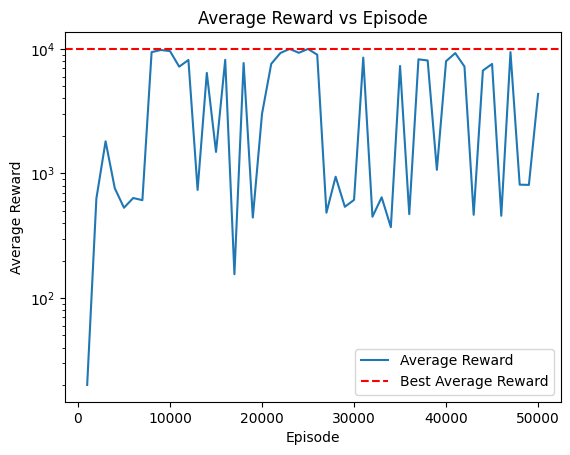

In [297]:
policy, Q, avg_rewards, episodes, best_policy, best_avg_reward = sarsa_lambda_agent(
    env, 50000, 0.02, lambda_=0.9
)

plt.plot(episodes, avg_rewards, label="Average Reward")
plt.axhline(best_avg_reward, color="r", linestyle="--", label="Best Average Reward")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.yscale("log")
plt.legend()
plt.title("Average Reward vs Episode")
plt.show()

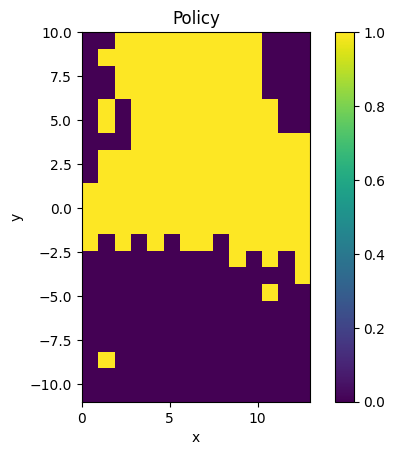

In [298]:
plot_policy(best_policy)